# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology. We analyze the flow across a rectangular channel containing a fixed cylinder as an obstacle, and display the evolution of velocity and pressure, with different Reynolds numbers and mesh resolutions.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2023-04-03 10:12:49--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-04-03 10:12:49 (40.0 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/f865b92/releases/pybind11-install.s

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method** \
We will in this report analyze 6 problems. The first 4 are using a mesh of resolution h=1/32 with respective Reynolds numbers Re=1, 10, 100 and 1000. Problem 5 is using Re=100 with h=1/8 and problem 6 is using Re=100 with h=1/16, to compare the mesh resolution effect on turbulent flows. 

**Define domain and mesh**\
Because we use 3 different mesh resolutions, see above, we define 3 meshes below.

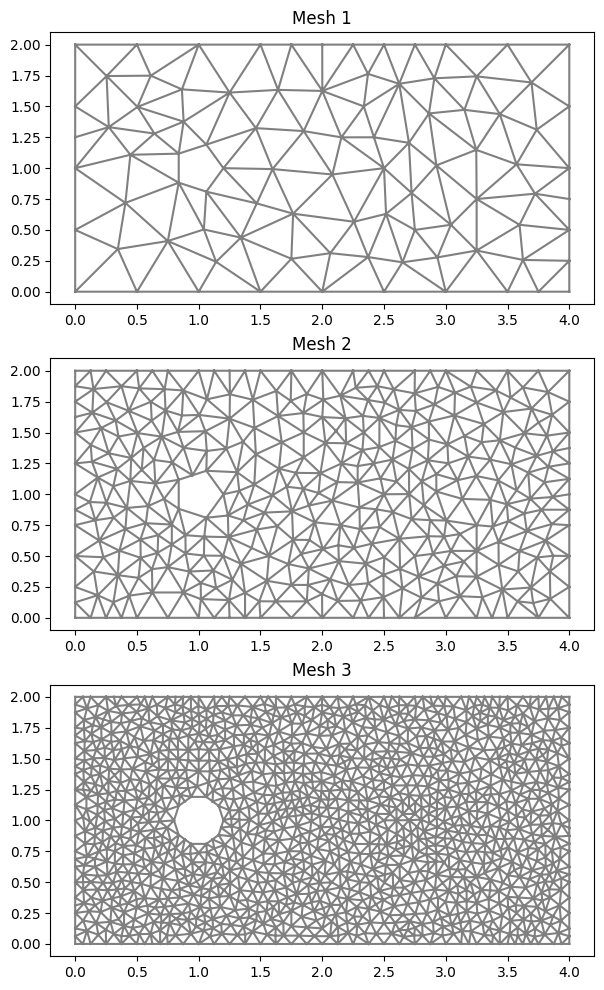

In [3]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution_1 = 8
resolution_2 = 16
resolution_3 = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh_1 = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution_1)
mesh_2 = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution_2)
mesh_3 = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution_3)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries_1 = MeshFunction("size_t", mesh_1, mesh_1.topology().dim()-1); boundaries_2 = MeshFunction("size_t", mesh_1, mesh_1.topology().dim()-1); boundaries_3 = MeshFunction("size_t", mesh_1, mesh_1.topology().dim()-1)
boundaries_1.set_all(0); boundaries_2.set_all(0); boundaries_3.set_all(0)
left.mark(boundaries_1, 1); left.mark(boundaries_2, 1); left.mark(boundaries_3, 1)
right.mark(boundaries_1, 2); right.mark(boundaries_2, 2); right.mark(boundaries_3, 2)
lower.mark(boundaries_1, 3); lower.mark(boundaries_2, 3); lower.mark(boundaries_3, 3)
upper.mark(boundaries_1, 4); upper.mark(boundaries_2, 4); upper.mark(boundaries_3, 4)

plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1); plot(mesh_1); plt.title('Mesh 1')
plt.subplot(3, 1, 2); plot(mesh_2); plt.title('Mesh 2')
plt.subplot(3, 1, 3); plot(mesh_3); plt.title('Mesh 3')
plt.show()

**Define finite element approximation spaces**\
We define three sets of finite elements spaces for each mesh, and we define for each of the 6 problems the trial and test functions according to the corresponding mesh.

In [4]:
# Generate finite element spaces (for velocity and pressure)
V_1 = VectorFunctionSpace(mesh_1, "Lagrange", 1); V_2 = VectorFunctionSpace(mesh_2, "Lagrange", 1); V_3 = VectorFunctionSpace(mesh_3, "Lagrange", 1)
Q_1 = FunctionSpace(mesh_1, "Lagrange", 1); Q_2 = FunctionSpace(mesh_2, "Lagrange", 1); Q_3 = FunctionSpace(mesh_3, "Lagrange", 1)

# Define trial and test functions 
u_1 = TrialFunction(V_3); u_2 = TrialFunction(V_3); u_3 = TrialFunction(V_3); u_4 = TrialFunction(V_3); u_5 = TrialFunction(V_1); u_6 = TrialFunction(V_2)
p_1 = TrialFunction(Q_3); p_2 = TrialFunction(Q_3); p_3 = TrialFunction(Q_3); p_4 = TrialFunction(Q_3); p_5 = TrialFunction(Q_1); p_6 = TrialFunction(Q_2)
v_1 = TestFunction(V_3); v_2 = TestFunction(V_3); v_3 = TestFunction(V_3); v_4 = TestFunction(V_3); v_5 = TestFunction(V_1); v_6 = TestFunction(V_2)
q_1 = TestFunction(Q_3); q_2 = TestFunction(Q_3); q_3 = TestFunction(Q_3); q_4 = TestFunction(Q_3); q_5 = TestFunction(Q_1); q_6 = TestFunction(Q_2)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0120838 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.487758 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00474906 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0172033 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

**Define boundary conditions**\
The first 4 problems have the same boundary condition expression because they have the same mesh. We define then two other boundary conditions sets of expression for problem 5 and 6.

In [5]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V_3.sub(0), uin, dbc_left); bcu_in0_5 = DirichletBC(V_1.sub(0), uin, dbc_left); bcu_in0_6 = DirichletBC(V_2.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V_3.sub(1), 0.0, dbc_left); bcu_in1_5 = DirichletBC(V_1.sub(1), 0.0, dbc_left); bcu_in1_6 = DirichletBC(V_2.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V_3.sub(0), 0.0, dbc_upper); bcu_upp0_5 = DirichletBC(V_1.sub(0), 0.0, dbc_upper); bcu_upp0_6 = DirichletBC(V_2.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V_3.sub(1), 0.0, dbc_upper); bcu_upp1_5 = DirichletBC(V_1.sub(1), 0.0, dbc_upper); bcu_upp1_6 = DirichletBC(V_2.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V_3.sub(0), 0.0, dbc_lower); bcu_low0_5 = DirichletBC(V_1.sub(0), 0.0, dbc_lower); bcu_low0_6 = DirichletBC(V_2.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V_3.sub(1), 0.0, dbc_lower); bcu_low1_5 = DirichletBC(V_1.sub(1), 0.0, dbc_lower); bcu_low1_6 = DirichletBC(V_2.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V_3.sub(0), 0.0, dbc_objects); bcu_obj0_5 = DirichletBC(V_1.sub(0), 0.0, dbc_objects); bcu_obj0_6 = DirichletBC(V_2.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V_3.sub(1), 0.0, dbc_objects); bcu_obj1_5 = DirichletBC(V_1.sub(1), 0.0, dbc_objects); bcu_obj1_6 = DirichletBC(V_2.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q_3.ufl_element(), t=0.0); pin_5 = Expression('5.0*fabs(sin(t))', element = Q_1.ufl_element(), t=0.0); pin_6 = Expression('5.0*fabs(sin(t))', element = Q_2.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q_3, pout, dbc_right); bcp1_5 = DirichletBC(Q_1, pout, dbc_right); bcp1_6 = DirichletBC(Q_2, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]; bcu_5 = [bcu_in0_5, bcu_in1_5, bcu_upp1_5, bcu_low1_5, bcu_obj0_5, bcu_obj1_5]; bcu_6 = [bcu_in0_6, bcu_in1_6, bcu_upp1_6, bcu_low1_6, bcu_obj0_6, bcu_obj1_6]
bcp = [bcp1]; bcp_5 = [bcp1_5]; bcp_6 = [bcp1_6]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh_3, subdomain_data=boundaries_3); ds_5 = Measure('ds', domain=mesh_1, subdomain_data=boundaries_1); ds_6 = Measure('ds', domain=mesh_2, subdomain_data=boundaries_2)

# **Results**

**Define flow parameters**\
There are 4 different Reynold numbers used in this report. Recall $Re=\frac{UD}{\nu}$, with the fluid velocity $U=1$ and diameter of cylinder $D=2r_c=0.4$. In order to get $Re=1, 10, 100, 1000$ we can vary $\nu$ correspondingly to the values $\nu= 4.{10}^{-1}, 4.{10}^{-2}, 4.{10}^{-3}, 4.{10}^{-4}$.

In [6]:
# Set viscosity
nu_1 = 4.0e-1
nu_2 = 4.0e-2
nu_3 = 4.0e-3
nu_4 = 4.0e-4

**Define method parameters**\
We still define all variables for each of the 6 problems. Note we take here the same time steps for each problem, regardless the different meshes, by taking the time step according to the finest mesh (mesh_3).

In [7]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0_1 = Function(V_3); u0_2 = Function(V_3); u0_3 = Function(V_3); u0_4 = Function(V_3); u0_5 = Function(V_1); u0_6 = Function(V_2)
u1_1 = Function(V_3); u1_2 = Function(V_3); u1_3 = Function(V_3); u1_4 = Function(V_3); u1_5 = Function(V_1); u1_6 = Function(V_2)
p0_1 = Function(Q_3); p0_2 = Function(Q_3); p0_3 = Function(Q_3); p0_4 = Function(Q_3); p0_5 = Function(Q_1); p0_6 = Function(Q_2)
p1_1 = Function(Q_3); p1_2 = Function(Q_3); p1_3 = Function(Q_3); p1_4 = Function(Q_3); p1_5 = Function(Q_1); p1_6 = Function(Q_2)

# Set parameters for nonlinear and linear solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh_3.hmin(); dt_5 = dt; dt_6 = dt 

**Define variational problem**\
We still take into account the 6 problem definitions.

In [8]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh_3); h_5 = CellDiameter(mesh_1); h_6 = CellDiameter(mesh_2);
u_mag_1 = sqrt(dot(u1_1,u1_1)); u_mag_2 = sqrt(dot(u1_2,u1_2)); u_mag_3 = sqrt(dot(u1_3,u1_3)); u_mag_4 = sqrt(dot(u1_4,u1_4)); u_mag_5 = sqrt(dot(u1_5,u1_5)); u_mag_6 = sqrt(dot(u1_6,u1_6))
d1_1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag_1/h,2.0))); d1_2 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag_2/h,2.0))); d1_3 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag_3/h,2.0))); d1_4 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag_4/h,2.0))); d1_5 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag_5/h_5,2.0))); d1_6 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag_6/h_6,2.0)))
d2_1 = h*u_mag_1; d2_2 = h*u_mag_2; d2_3 = h*u_mag_3; d2_4 = h*u_mag_4; d2_5 = h_5*u_mag_5; d2_6 = h_6*u_mag_6

# Mean velocities for trapozoidal time stepping
um_1 = 0.5*(u_1 + u0_1); um_2 = 0.5*(u_2 + u0_2); um_3 = 0.5*(u_3 + u0_3); um_4 = 0.5*(u_4 + u0_4); um_5 = 0.5*(u_5 + u0_5); um_6 = 0.5*(u_6 + u0_6)
um1_1 = 0.5*(u1_1 + u0_1); um1_2 = 0.5*(u1_2 + u0_2); um1_3 = 0.5*(u1_3 + u0_3); um1_4 = 0.5*(u1_4 + u0_4); um1_5 = 0.5*(u1_5 + u0_5); um1_6 = 0.5*(u1_6 + u0_6)

# Momentum variational equation on residual form
Fu_1 = inner((u_1 - u0_1)/dt + grad(um_1)*um1_1, v_1)*dx - p1_1*div(v_1)*dx + nu_1*inner(grad(um_1), grad(v_1))*dx \
    + d1_1*inner((u_1 - u0_1)/dt + grad(um_1)*um1_1 + grad(p1_1), grad(v_1)*um1_1)*dx + d2_1*div(um_1)*div(v_1)*dx 
Fu_2 = inner((u_2 - u0_2)/dt + grad(um_2)*um1_2, v_2)*dx - p1_2*div(v_2)*dx + nu_2*inner(grad(um_2), grad(v_2))*dx \
    + d1_2*inner((u_2 - u0_2)/dt + grad(um_2)*um1_2 + grad(p1_2), grad(v_2)*um1_2)*dx + d2_2*div(um_2)*div(v_2)*dx 
Fu_3 = inner((u_3 - u0_3)/dt + grad(um_3)*um1_3, v_3)*dx - p1_3*div(v_3)*dx + nu_3*inner(grad(um_3), grad(v_3))*dx \
    + d1_3*inner((u_3 - u0_3)/dt + grad(um_3)*um1_3 + grad(p1_3), grad(v_3)*um1_3)*dx + d2_3*div(um_3)*div(v_3)*dx 
Fu_4 = inner((u_4 - u0_4)/dt + grad(um_4)*um1_4, v_4)*dx - p1_4*div(v_4)*dx + nu_4*inner(grad(um_4), grad(v_4))*dx \
    + d1_4*inner((u_4 - u0_4)/dt + grad(um_4)*um1_4 + grad(p1_4), grad(v_4)*um1_4)*dx + d2_4*div(um_4)*div(v_4)*dx 
Fu_5 = inner((u_5 - u0_5)/dt + grad(um_5)*um1_5, v_5)*dx - p1_5*div(v_5)*dx + nu_3*inner(grad(um_5), grad(v_5))*dx \
    + d1_5*inner((u_5 - u0_5)/dt_5 + grad(um_5)*um1_5 + grad(p1_5), grad(v_5)*um1_5)*dx + d2_5*div(um_5)*div(v_5)*dx
Fu_6 = inner((u_6 - u0_6)/dt + grad(um_6)*um1_6, v_6)*dx - p1_6*div(v_6)*dx + nu_3*inner(grad(um_6), grad(v_6))*dx \
    + d1_6*inner((u_6 - u0_6)/dt_6 + grad(um_6)*um1_6 + grad(p1_6), grad(v_6)*um1_6)*dx + d2_6*div(um_6)*div(v_6)*dx  
au_1 = lhs(Fu_1); au_2 = lhs(Fu_2); au_3 = lhs(Fu_3); au_4 = lhs(Fu_4); au_5 = lhs(Fu_5); au_6 = lhs(Fu_6)
Lu_1 = rhs(Fu_1); Lu_2 = rhs(Fu_2); Lu_3 = rhs(Fu_3); Lu_4 = rhs(Fu_4); Lu_5 = rhs(Fu_5); Lu_6 = rhs(Fu_6)

# Continuity variational equation on residual form
Fp_1 = d1_1*inner((u1_1 - u0_1)/dt + grad(um1_1)*um1_1 + grad(p_1), grad(q_1))*dx + div(um1_1)*q_1*dx 
Fp_2 = d1_2*inner((u1_2 - u0_2)/dt + grad(um1_2)*um1_2 + grad(p_2), grad(q_2))*dx + div(um1_2)*q_2*dx 
Fp_3 = d1_3*inner((u1_3 - u0_3)/dt + grad(um1_3)*um1_3 + grad(p_3), grad(q_3))*dx + div(um1_3)*q_3*dx 
Fp_4 = d1_4*inner((u1_4 - u0_4)/dt + grad(um1_4)*um1_4 + grad(p_4), grad(q_4))*dx + div(um1_4)*q_4*dx 
Fp_5 = d1_5*inner((u1_5 - u0_5)/dt_5 + grad(um1_5)*um1_5 + grad(p_5), grad(q_5))*dx + div(um1_5)*q_5*dx
Fp_6 = d1_6*inner((u1_6 - u0_6)/dt_6 + grad(um1_6)*um1_6 + grad(p_6), grad(q_6))*dx + div(um1_6)*q_6*dx
ap_1 = lhs(Fp_1); ap_2 = lhs(Fp_2); ap_3 = lhs(Fp_3); ap_4 = lhs(Fp_4); ap_5 = lhs(Fp_5); ap_6 = lhs(Fp_6)
Lp_1 = rhs(Fp_1); Lp_2 = rhs(Fp_2); Lp_3 = rhs(Fp_3); Lp_4 = rhs(Fp_4); Lp_5 = rhs(Fp_5); Lp_6 = rhs(Fp_6)

**Compute force on boundary**\
Here we keep track of the expressions for respectively the drag and lift force for each of the 6 problems.

In [9]:
# Define the direction of the lift force 
phi_x1 = 0.0
phi_y1 = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression_1 = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x1, phi_y=phi_y1, element = V_3.ufl_element())
psi_expression_1_5 = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x1, phi_y=phi_y1, element = V_1.ufl_element())
psi_expression_1_6 = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x1, phi_y=phi_y1, element = V_2.ufl_element())
psi_1 = interpolate(psi_expression_1, V_3); psi_1_5 = interpolate(psi_expression_1_5, V_1); psi_1_6 = interpolate(psi_expression_1_6, V_2)

lift_force_1 = inner((u1_1 - u0_1)/dt + grad(um1_1)*um1_1, psi_1)*dx - p1_1*div(psi_1)*dx + nu_1*inner(grad(um1_1), grad(psi_1))*dx
lift_force_2 = inner((u1_2 - u0_2)/dt + grad(um1_2)*um1_2, psi_1)*dx - p1_2*div(psi_1)*dx + nu_2*inner(grad(um1_2), grad(psi_1))*dx
lift_force_3 = inner((u1_3 - u0_3)/dt + grad(um1_3)*um1_3, psi_1)*dx - p1_3*div(psi_1)*dx + nu_3*inner(grad(um1_3), grad(psi_1))*dx
lift_force_4 = inner((u1_4 - u0_4)/dt + grad(um1_4)*um1_4, psi_1)*dx - p1_4*div(psi_1)*dx + nu_4*inner(grad(um1_4), grad(psi_1))*dx
lift_force_5 = inner((u1_5 - u0_5)/dt_5 + grad(um1_5)*um1_5, psi_1_5)*dx - p1_5*div(psi_1_5)*dx + nu_3*inner(grad(um1_5), grad(psi_1_5))*dx
lift_force_6 = inner((u1_6 - u0_6)/dt_6 + grad(um1_6)*um1_6, psi_1_6)*dx - p1_6*div(psi_1_6)*dx + nu_3*inner(grad(um1_6), grad(psi_1_6))*dx

# Define the direction of the drag force 
phi_x2 = 1.0
phi_y2 = 0.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression_2 = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x2, phi_y=phi_y2, element = V_3.ufl_element())
psi_expression_2_5 = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x2, phi_y=phi_y2, element = V_1.ufl_element())
psi_expression_2_6 = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x2, phi_y=phi_y2, element = V_2.ufl_element())
psi_2 = interpolate(psi_expression_2, V_3); psi_2_5 = interpolate(psi_expression_2_5, V_1); psi_2_6 = interpolate(psi_expression_2_6, V_2)

drag_force_1 = inner((u1_1 - u0_1)/dt + grad(um1_1)*um1_1, psi_2)*dx - p1_1*div(psi_2)*dx + nu_1*inner(grad(um1_1), grad(psi_2))*dx
drag_force_2 = inner((u1_2 - u0_2)/dt + grad(um1_2)*um1_2, psi_2)*dx - p1_2*div(psi_2)*dx + nu_2*inner(grad(um1_2), grad(psi_2))*dx
drag_force_3 = inner((u1_3 - u0_3)/dt + grad(um1_3)*um1_3, psi_2)*dx - p1_3*div(psi_2)*dx + nu_3*inner(grad(um1_3), grad(psi_2))*dx
drag_force_4 = inner((u1_4 - u0_4)/dt + grad(um1_4)*um1_4, psi_2)*dx - p1_4*div(psi_2)*dx + nu_4*inner(grad(um1_4), grad(psi_2))*dx
drag_force_5 = inner((u1_5 - u0_5)/dt_5 + grad(um1_5)*um1_5, psi_2_5)*dx - p1_5*div(psi_2_5)*dx + nu_3*inner(grad(um1_5), grad(psi_2_5))*dx
drag_force_6 = inner((u1_6 - u0_6)/dt_6 + grad(um1_6)*um1_6, psi_2_6)*dx - p1_6*div(psi_2_6)*dx + nu_3*inner(grad(um1_6), grad(psi_2_6))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [10]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data 
force_array_lift_1 = np.array(0.0); force_array_lift_2 = np.array(0.0); force_array_lift_3 = np.array(0.0); force_array_lift_4 = np.array(0.0); force_array_lift_5 = np.array(0.0); force_array_lift_6 = np.array(0.0)
force_array_lift_1 = np.delete(force_array_lift_1, 0); force_array_lift_2 = np.delete(force_array_lift_2, 0); force_array_lift_3 = np.delete(force_array_lift_3, 0); force_array_lift_4 = np.delete(force_array_lift_4, 0); force_array_lift_5 = np.delete(force_array_lift_5, 0); force_array_lift_6 = np.delete(force_array_lift_6, 0)
force_array_drag_1 = np.array(0.0); force_array_drag_2 = np.array(0.0); force_array_drag_3 = np.array(0.0); force_array_drag_4 = np.array(0.0); force_array_drag_5 = np.array(0.0); force_array_drag_6 = np.array(0.0)
force_array_drag_1 = np.delete(force_array_drag_1, 0); force_array_drag_2 = np.delete(force_array_drag_2, 0); force_array_drag_3 = np.delete(force_array_drag_3, 0); force_array_drag_4 = np.delete(force_array_drag_4, 0); force_array_drag_5 = np.delete(force_array_drag_5, 0); force_array_drag_6 = np.delete(force_array_drag_6, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**\
Here we plot on a time period $T=30$ the 4 first problems with mesh resolution $h=1/32$ with respectively $Re=1,10,100,1000$. At each plot time (10 in total), we plot for each Reynold number the velocity field and pressure distribution in the channel. We also plot the lift and drag forces evolution between $t=0$ up to the current plot time.

In [11]:
!rm results-NS/*

# Time stepping 
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au_1 = assemble(au_1); Au_2 = assemble(au_2); Au_3 = assemble(au_3); Au_4 = assemble(au_4)
        bu_1 = assemble(Lu_1); bu_2 = assemble(Lu_2); bu_3 = assemble(Lu_3); bu_4 = assemble(Lu_4)

        # Compute velocity solution 
        [bc.apply(Au_1, bu_1) for bc in bcu]; [bc.apply(Au_2, bu_2) for bc in bcu]; [bc.apply(Au_3, bu_3) for bc in bcu]; [bc.apply(Au_4, bu_4) for bc in bcu]
        [bc.apply(u1_1.vector()) for bc in bcu]; [bc.apply(u1_2.vector()) for bc in bcu]; [bc.apply(u1_3.vector()) for bc in bcu]; [bc.apply(u1_4.vector()) for bc in bcu]
        solve(Au_1, u1_1.vector(), bu_1, "bicgstab", "default"); solve(Au_2, u1_2.vector(), bu_2, "bicgstab", "default"); solve(Au_3, u1_3.vector(), bu_3, "bicgstab", "default"); solve(Au_4, u1_4.vector(), bu_4, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap_1 = assemble(ap_1); Ap_2 = assemble(ap_2); Ap_3 = assemble(ap_3); Ap_4 = assemble(ap_4)
        bp_1 = assemble(Lp_1); bp_2 = assemble(Lp_2); bp_3 = assemble(Lp_3); bp_4 = assemble(Lp_4)

        # Compute pressure solution 
        [bc.apply(Ap_1, bp_1) for bc in bcp]; [bc.apply(Ap_2, bp_2) for bc in bcp]; [bc.apply(Ap_3, bp_3) for bc in bcp]; [bc.apply(Ap_4, bp_4) for bc in bcp]
        [bc.apply(p1_1.vector()) for bc in bcp]; [bc.apply(p1_2.vector()) for bc in bcp]; [bc.apply(p1_3.vector()) for bc in bcp]; [bc.apply(p1_4.vector()) for bc in bcp]
        solve(Ap_1, p1_1.vector(), bp_1, "bicgstab", prec); solve(Ap_2, p1_2.vector(), bp_2, "bicgstab", prec); solve(Ap_3, p1_3.vector(), bp_3, "bicgstab", prec); solve(Ap_4, p1_4.vector(), bp_4, "bicgstab", prec)

        # Compute force
        FD_1 = assemble(drag_force_1); FD_2 = assemble(drag_force_2); FD_3 = assemble(drag_force_3); FD_4 = assemble(drag_force_4)
        FL_1 = assemble(lift_force_1); FL_2 = assemble(lift_force_2); FL_3 = assemble(lift_force_3); FL_4 = assemble(lift_force_4)
        if (t > start_sample_time):
          force_array_drag_1 = np.append(force_array_drag_1, normalization*FD_1); force_array_drag_2 = np.append(force_array_drag_2, normalization*FD_2); force_array_drag_3 = np.append(force_array_drag_3, normalization*FD_3); force_array_drag_4 = np.append(force_array_drag_4, normalization*FD_4)
          force_array_lift_1 = np.append(force_array_lift_1, normalization*FL_1); force_array_lift_2 = np.append(force_array_lift_2, normalization*FL_2); force_array_lift_3 = np.append(force_array_lift_3, normalization*FL_3); force_array_lift_4 = np.append(force_array_lift_4, normalization*FL_4)
          time = np.append(time, t)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1_3
        file_p << p1_3 

        # Plot solution
        # Re = 1
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1); plot(u1_1, title="Velocity Re=1")
        plt.subplot(2, 2, 2); plot(p1_1, title="Pressure Re=1"); 
        plt.subplot(2, 2, 3); plt.title("Drag force Re=1"); plt.plot(time, force_array_drag_1)
        plt.subplot(2, 2, 4); plt.title("lift force Re=1"); plt.plot(time, force_array_lift_1)
        plt.show()
        if len(force_array_drag_1) != 0:
          print("For Re=1, the current estimated $C_D$=",(sum((force_array_drag_1)**2)/len(force_array_drag_1))**(1/2))
        if len(force_array_lift_1) != 0:
          print("For Re=1, the current estimated $C_L$=",(sum((force_array_lift_1)**2)/len(force_array_lift_1))**(1/2))

        # Re = 10
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1); plot(u1_2, title="Velocity Re=10")
        plt.subplot(2, 2, 2); plot(p1_2, title="Pressure Re=10"); 
        plt.subplot(2, 2, 3); plt.title("Drag force Re=10"); plt.plot(time, force_array_drag_2)
        plt.subplot(2, 2, 4); plt.title("lift force Re=10"); plt.plot(time, force_array_lift_2)
        plt.show()
        if len(force_array_drag_2) != 0:
          print("For Re=10, the current estimated $C_D$=",(sum((force_array_drag_2)**2)/len(force_array_drag_2))**(1/2))
        if len(force_array_lift_2) != 0:
          print("For Re=10, the current estimated $C_L$=",(sum((force_array_lift_2)**2)/len(force_array_lift_2))**(1/2))

        # Re = 100
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1); plot(u1_3, title="Velocity Re=100")
        plt.subplot(2, 2, 2); plot(p1_3, title="Pressure Re=100"); 
        plt.subplot(2, 2, 3); plt.title("Drag force Re=100"); plt.plot(time, force_array_drag_3)
        plt.subplot(2, 2, 4); plt.title("lift force Re=100"); plt.plot(time, force_array_lift_3)
        plt.show()
        if len(force_array_drag_3) != 0:
          print("For Re=100, the current estimated $C_D$=",(sum((force_array_drag_3)**2)/len(force_array_drag_3))**(1/2))
        if len(force_array_lift_3) != 0:
          print("For Re=100, the current estimated $C_L$=",(sum((force_array_lift_3)**2)/len(force_array_lift_3))**(1/2))

        # Re = 1000
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1); plot(u1_4, title="Velocity Re=1000")
        plt.subplot(2, 2, 2); plot(p1_4, title="Pressure Re=1000"); 
        plt.subplot(2, 2, 3); plt.title("Drag force Re=1000"); plt.plot(time, force_array_drag_4)
        plt.subplot(2, 2, 4); plt.title("lift force Re=1000"); plt.plot(time, force_array_lift_4)
        plt.show()
        if len(force_array_drag_4) != 0:
          print("For Re=1000, the current estimated $C_D$=",(sum((force_array_drag_4)**2)/len(force_array_drag_4))**(1/2))
        if len(force_array_lift_4) != 0:
          print("For Re=1000, the current estimated $C_L$=",(sum((force_array_lift_4)**2)/len(force_array_lift_4))**(1/2))

        plot_time += T/plot_freq
        

    # Update time step
    u0_1.assign(u1_1); u0_2.assign(u1_2); u0_3.assign(u1_3); u0_4.assign(u1_4)
    t += dt 

!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')

Output hidden; open in https://colab.research.google.com to view.

We can see above that all flows need a certain time to get into a cyclic or constant dynamic after encountering the obstacle. For Reynolds $Re=1$ and $Re=10$, we get that the velocity and pressure profiles become steady. We can also see it by seeing that both the lift and drag forces converge to a particular value, so the lift and drag coefficients (see expression in the introduction) are also converging to the adimensionalization value of those respective forces. Indeed for $Re=1$, we get approximatetly $C_D=17.72$ and $C_L=0.038$. For $Re=10$, we get $C_D=3.61$ and $C_L=0.052$.\
For the higher Reynolds numbers, we see that the flow is not steady anymore. We clearly see a von Karman vortex street after the cylinder, by seeing the velocity field changing direction every time step and by seeing the pressure distribution that has low-pressure moving zones after the obstacle. We can also notice it with the oscillations of both drag and lift coefficients, with both an approximated oscillation frequency $f=1/2$ (one oscillation every period $T=2$). To get the lift and drag coefficients, we then use the RMS value, which gives the following values. For $Re=100$, we get $C_D=1.70$ and $C_L=0.25$, and for $Re=1000$ we get $C_D=1.56$ and $C_L=0.44$. Note that the Strouhal number $St=\frac{fD}{U}=0.2$ for both high Reynolds numbers, as expected.\
We can see that the higher the Reynolds, the higher the lift coefficient and the lower the drag coefficient, due to the turbulences.

Next, we compute and plot the evolution of velocity, pressure, lift and drag forces for $Re=100$ for the two other mesh resolutions $h=1/8$ (problem 5) and $h=1/16$ (problem 6). We then compare after with the solution with resolution $h=1/32$ above.

In [12]:
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

plot_time = 0
plot_freq = 10

# Time stepping 
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin_5.t = t; pin_6.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au_5 = assemble(au_5); Au_6 = assemble(au_6)
        bu_5 = assemble(Lu_5); bu_6 = assemble(Lu_6)

        # Compute velocity solution 
        [bc.apply(Au_5, bu_5) for bc in bcu_5]; [bc.apply(Au_6, bu_6) for bc in bcu_6]
        [bc.apply(u1_5.vector()) for bc in bcu_5]; [bc.apply(u1_6.vector()) for bc in bcu_6]
        solve(Au_5, u1_5.vector(), bu_5, "bicgstab", "default"); solve(Au_6, u1_6.vector(), bu_6, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap_5 = assemble(ap_5); Ap_6 = assemble(ap_6)
        bp_5 = assemble(Lp_5); bp_6 = assemble(Lp_6)

        # Compute pressure solution 
        [bc.apply(Ap_5, bp_5) for bc in bcp_5]; [bc.apply(Ap_6, bp_6) for bc in bcp_6]
        [bc.apply(p1_5.vector()) for bc in bcp_5]; [bc.apply(p1_6.vector()) for bc in bcp_6]
        solve(Ap_5, p1_5.vector(), bp_5, "bicgstab", prec); solve(Ap_6, p1_6.vector(), bp_6, "bicgstab", prec)

        # Compute force
        FD_5 = assemble(drag_force_5); FD_6 = assemble(drag_force_6)
        FL_5 = assemble(lift_force_5); FL_6 = assemble(lift_force_6)
        if (t > start_sample_time):
          force_array_drag_5 = np.append(force_array_drag_5, normalization*FD_5); force_array_drag_6 = np.append(force_array_drag_6, normalization*FD_6)
          force_array_lift_5 = np.append(force_array_lift_5, normalization*FL_5); force_array_lift_6 = np.append(force_array_lift_6, normalization*FL_6)
          time = np.append(time, t)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        ''' file_u << u1
        file_p << p1 '''

        # Plot solution
        # Re = 100 mesh h=1/8
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1); plot(u1_5, title="Velocity Re=100 mesh h=1/8")
        plt.subplot(2, 2, 2); plot(p1_6, title="Pressure Re=100 mesh h=1/8"); 
        plt.subplot(2, 2, 3); plt.title("Drag force Re=100 mesh h=1/8"); plt.plot(time, force_array_drag_5)
        plt.subplot(2, 2, 4); plt.title("lift force Re=100 mesh h=1/8"); plt.plot(time, force_array_lift_5)
        plt.show()
        if len(force_array_drag_5) != 0:
          print("For Re=100 mesh h=1/8, the current estimated $C_D$=",(sum((force_array_drag_5)**2)/len(force_array_drag_5))**(1/2))
        if len(force_array_lift_5) != 0:
          print("For Re=100 mesh h=1/8, the current estimated $C_L$=",(sum((force_array_lift_5)**2)/len(force_array_lift_5))**(1/2))

        # Re = 100 mesh h=1/16
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1); plot(u1_6, title="Velocity Re=100 mesh h=1/16")
        plt.subplot(2, 2, 2); plot(p1_6, title="Pressure Re=100 mesh h=1/16"); 
        plt.subplot(2, 2, 3); plt.title("Drag force Re=100 mesh h=1/16"); plt.plot(time, force_array_drag_6)
        plt.subplot(2, 2, 4); plt.title("lift force Re=100 mesh h=1/16"); plt.plot(time, force_array_lift_6)
        plt.show()
        if len(force_array_drag_6) != 0:
          print("For Re=100 mesh h=1/16, the current estimated $C_D$=",(sum((force_array_drag_6)**2)/len(force_array_drag_6))**(1/2))
        if len(force_array_lift_6) != 0:
          print("For Re=100 mesh h=1/16, the current estimated $C_L$=",(sum((force_array_lift_6)**2)/len(force_array_lift_6))**(1/2))

        plot_time += T/plot_freq
        

    # Update time step
    u0_5.assign(u1_5); u0_6.assign(u1_6)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

Output hidden; open in https://colab.research.google.com to view.

In these simulations with $Re=100$ and resolutions $h=1/8$ and $h=1/16$, we also see a von Karman vortex street as expected. The velocity and pressure profiles seem to behave quite similarly to the previous resolution $h=1/32$. However, the drag and lift forces (or coeffcients) behave differently in value or in shape. Indeed, for $h=1/8$, there some small oscillations but both forces seem to converge to a value, wihich was not the case for the finer resolution.We then get $C_D=3.69$ and $C_L=0.29$. \
For $h=1/16$, the forces oscillations are closer to the behavior with finer resolution. It gives the coefficients $C_D=2.13$ and $C_L=0.15$. 

If we compare all this with the higher resolution $h=1/32$, where we got $C_D=1.70$ and $C_L=0.25$, we can see that the drag coefficient is much closer to when $h=1/16$ than $h=1/8$, which shows convergence. On the other hand, the estimated values of $C_D$ (for $h=1/8$ and $1/16$) are quite equivalent from the high resolution. However, the behavior of the drag force is completely different between $h=1/8$ and $h=1/16$, where $h=1/16$ is closer to the fine mesh $h=1/32$. Therefore we conclude the solution becomes more consistent as the resolution is finer, and seem to converge. 
For $h=1/8$ the forces do not oscillate really so it is hard to give a proper frequency. For $h=1/16$, the oscillation frequency seems to be a bit lower than for $h=1/32$, let's say $f=2/5$, so the approximated Strouhal number is $St=0.16$, in comparison with $St=0.2$ as previously.

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, for different Reynolds numbers $Re=1,10,100,1000$. We also analyzed the impact of the mesh resolution for the case $Re=100$. We can conclude with the aove results that for high enough Reynolds numbers, we see [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street), here for $Re=100$ and $1000$. On the other hand, for low Reynolds numbers the flows seems to be steady, there are no oscillations in the velocity field and on the lift and drag forces plots.

Moreover, when we compare the resoluts with $Re=100$ with thicker resolutions, we see that the results still show von Karman vortex street, however the oscillations in the drag and lift forces are not that representative, especially for the worst resolution $h=1/8$. The resolution $h=1/16$ seems to showa behavior closer to the finest resolution $h=1/32$, which shows the importance of refining the mesh.

There is also besides this report a film realized thanks to open source Paraview tool for $Re=100$ and the the finest mesh. We can see in it the evolution of pressure and velocity in a better visual way.

To conclude, the reported illustrated important theories seen in the course. The code used stabilizing terms for a stable solution. We did not modify them as they seem to do the job and stabilize the solution.